# 03 - Preprocesssing & Modelling

## 3.1 Contents:<a id='2.1_Contents'></a>
* [3.2_Objective:](#2.2_Objective:)
* [3.3_Imports:](#2.3_Imports:)
* [3.4_Preprocessing:](#2.4_Preprocessing_Data:)

# 3.2 Objective:

# 3.3 Imports:

In [69]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

# For time stamps
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## Define Key Variables:

In [119]:
train_split_percentage = 0.90
seq_length = 30 # for LSTM model

## 3.3.1 Load Data:

In [10]:
df_load = pd.read_csv('../data/processed/df_cleaned.csv')

In [11]:
# Set the 'Date' column back to the index
# Convert 'Date' column to datetime
df_load['Date'] = pd.to_datetime(df_load['Date'])
df_load.set_index('Date', inplace=True)
df_load.head(10)

,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,symbol,actualEarningResult,estimatedEarning
Date,,,,,,,,,,,,,,,,
2019-07-05,TSLA,TESLA,15.638000,15.696667,15.386667,15.540000,15.540000,105985500,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2019-07-08,TSLA,TESLA,15.416000,15.483333,15.244000,15.356000,15.356000,88207500,-0.011840,NaN,NaN,NaN,-0.014678,NaN,NaN,NaN
2019-07-09,TSLA,TESLA,15.264667,15.400000,15.152000,15.337333,15.337333,92862000,-0.001216,NaN,NaN,NaN,-0.027500,NaN,NaN,NaN
2019-07-10,TSLA,TESLA,15.610000,15.929333,15.542667,15.928000,15.928000,137185500,0.038512,NaN,NaN,NaN,0.009887,NaN,NaN,NaN
2019-07-11,TSLA,TESLA,15.876000,16.100000,15.720000,15.906667,15.906667,112716000,-0.001339,NaN,NaN,NaN,0.037364,NaN,NaN,NaN
2019-07-12,TSLA,TESLA,15.983333,16.358667,15.980667,16.338667,16.338667,138007500,0.027158,NaN,NaN,NaN,0.092927,NaN,NaN,NaN
2019-07-15,TSLA,TESLA,16.533333,16.961332,16.323999,16.900000,16.900000,165001500,0.034356,NaN,NaN,NaN,0.180179,NaN,NaN,NaN
2019-07-16,TSLA,TESLA,16.620001,16.902000,16.528667,16.825333,16.825333,122235000,-0.004418,NaN,NaN,NaN,0.240530,NaN,NaN,NaN
2019-07-17,TSLA,TESLA,17.044666,17.220667,16.889999,16.990667,16.990667,146470500,0.009827,NaN,NaN,NaN,0.298261,NaN,NaN,NaN


In [12]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2019-07-05 to 2024-07-03
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        3774 non-null   object 
 1   company_name         3774 non-null   object 
 2   Open                 3774 non-null   float64
 3   High                 3774 non-null   float64
 4   Low                  3774 non-null   float64
 5   Close                3774 non-null   float64
 6   Adj Close            3774 non-null   float64
 7   Volume               3774 non-null   int64  
 8   Daily_Return         3771 non-null   float64
 9   30_MA                3687 non-null   float64
 10  90_MA                3507 non-null   float64
 11  RSI                  3735 non-null   float64
 12  MACD                 3774 non-null   float64
 13  symbol               60 non-null     object 
 14  actualEarningResult  3761 non-null   float64
 15  estimatedEarning    

In [13]:
# Dropping rows with null values for 90 day moving average, this should only clear the first ~90 days worth of data. 
df_load = df_load.dropna(subset=['90_MA'])
# Drop feature 'Symbol' dulplicate for ticker_symbol.
df_load = df_load.drop(columns = 'symbol')

In [14]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3507 entries, 2019-11-08 to 2024-07-03
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker_symbol        3507 non-null   object 
 1   company_name         3507 non-null   object 
 2   Open                 3507 non-null   float64
 3   High                 3507 non-null   float64
 4   Low                  3507 non-null   float64
 5   Close                3507 non-null   float64
 6   Adj Close            3507 non-null   float64
 7   Volume               3507 non-null   int64  
 8   Daily_Return         3507 non-null   float64
 9   30_MA                3507 non-null   float64
 10  90_MA                3507 non-null   float64
 11  RSI                  3507 non-null   float64
 12  MACD                 3507 non-null   float64
 13  actualEarningResult  3507 non-null   float64
 14  estimatedEarning     3507 non-null   float64
dtypes: float64(12), int6

# 3.4 Preprocessing Data:

In [311]:
# unzip df by stock and add it to a dictionary.
stock_data = {}
tech_list = df_load['ticker_symbol'].unique()
# Iterate over each unique ticker symbol in the DataFrame
for ticker in tech_list:
    # Filter the DataFrame for the current ticker symbol
    stock_df = df_load[df_load['ticker_symbol'] == ticker].copy()
    stock_df = stock_df[['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 
       'Adj Close', 'Volume', 'Daily_Return', '30_MA', '90_MA', 'RSI', 'MACD',
       'actualEarningResult', 'estimatedEarning', 'Close']]
    # Store the DataFrame in the dictionary
    stock_data[ticker] = stock_df
    
# Display the DataFrame for a specific stock, e.g., 'TSLA'
stock_data['TSLA'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2019-11-08,TSLA,TESLA,22.299999,22.497334,22.166668,22.476000,91038000,0.004768,18.476200,16.604963,86.182712,1.485719,0.12,0.01867,22.476000
2019-11-11,TSLA,TESLA,22.930000,23.279333,22.799999,23.006001,149800500,0.023581,18.707800,16.687919,86.850537,1.537215,0.12,0.01867,23.006001
2019-11-12,TSLA,TESLA,23.126667,23.358000,22.936001,23.328667,110391000,0.014025,18.941667,16.776504,87.981493,1.585782,0.12,0.01867,23.328667
2019-11-13,TSLA,TESLA,23.666668,23.755333,23.011999,23.073999,126301500,-0.010916,19.170511,16.862467,77.567972,1.585446,0.12,0.01867,23.073999
2019-11-14,TSLA,TESLA,23.073999,23.589333,22.860666,23.290001,96973500,0.009361,19.429000,16.944267,67.983043,1.584346,0.12,0.01867,23.290001


## 3.4.1 Dummy regressor:

### Train/Test Split Data:

In [313]:
# fuction to split df into train and test.
def train_test_data(df):
    X = df
    y = df['Close']
     # Calculate the split index, split percentage defined up top in imports. 
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    
    return X_train, X_test, y_train, y_test

split_data = {}
for stock in tech_list:
    split_data[stock] = train_test_data(stock_data[stock])

In [315]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(split_data['TSLA'][i].shape)

(1052, 15)
(116, 15)
(1052,)
(116,)


In [317]:
# Dummy regression training model function
def train_dummy(X_train, y_train):
    dumb_reg = DummyRegressor(strategy='mean')
    dumb_reg.fit(X_train, y_train)
    return dumb_reg

trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    trained_models[stock] = train_dummy(X_train, y_train)

In [319]:
# Dummy regression evaluation model function. 
def evaluate_models(model, X_test, y_test):
    results = {}  
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    results = {'MAE': mae, 'RMSE': rmse}
    return results

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    evaluation_results[stock] = evaluate_models(trained_models[stock], X_test, y_test)

for stock, results in evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")

Evaluation results for TSLA:
MAE = 23.56704599635073, RMSE = 26.604872360762545
Evaluation results for AMD:
MAE = 80.5728491337627, RMSE = 81.82046648342518
Evaluation results for NVDA:
MAE = 70.40171748347375, RMSE = 73.13299412067538


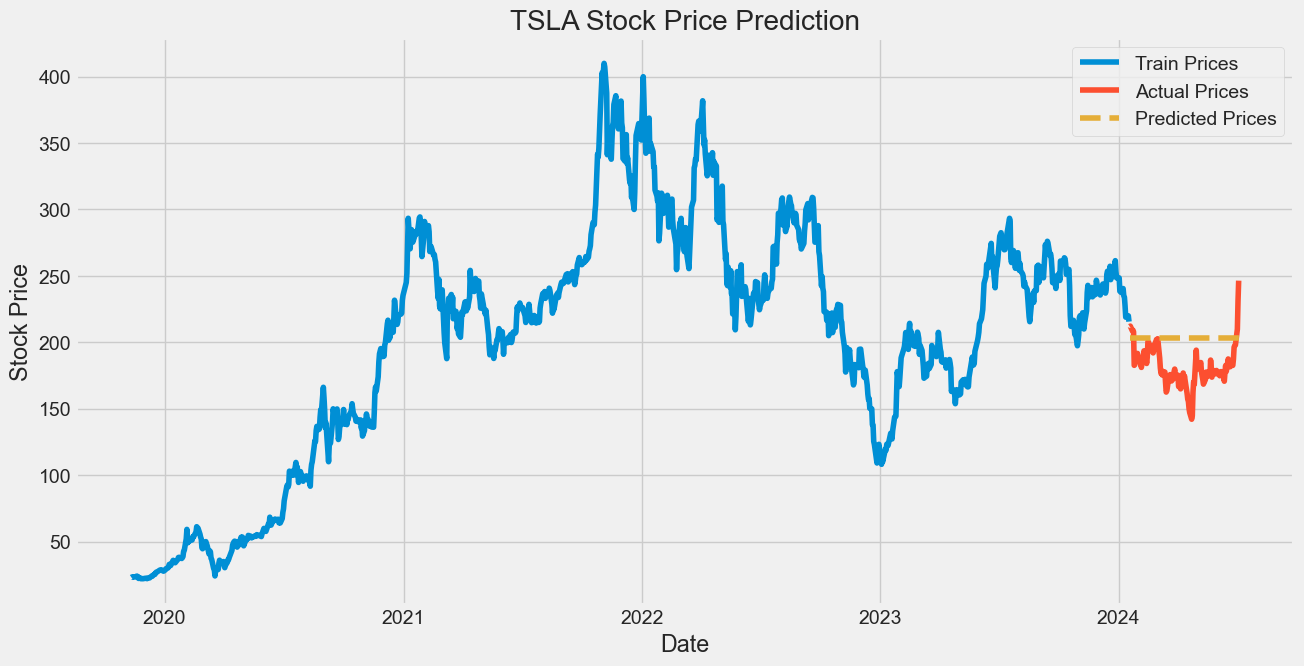

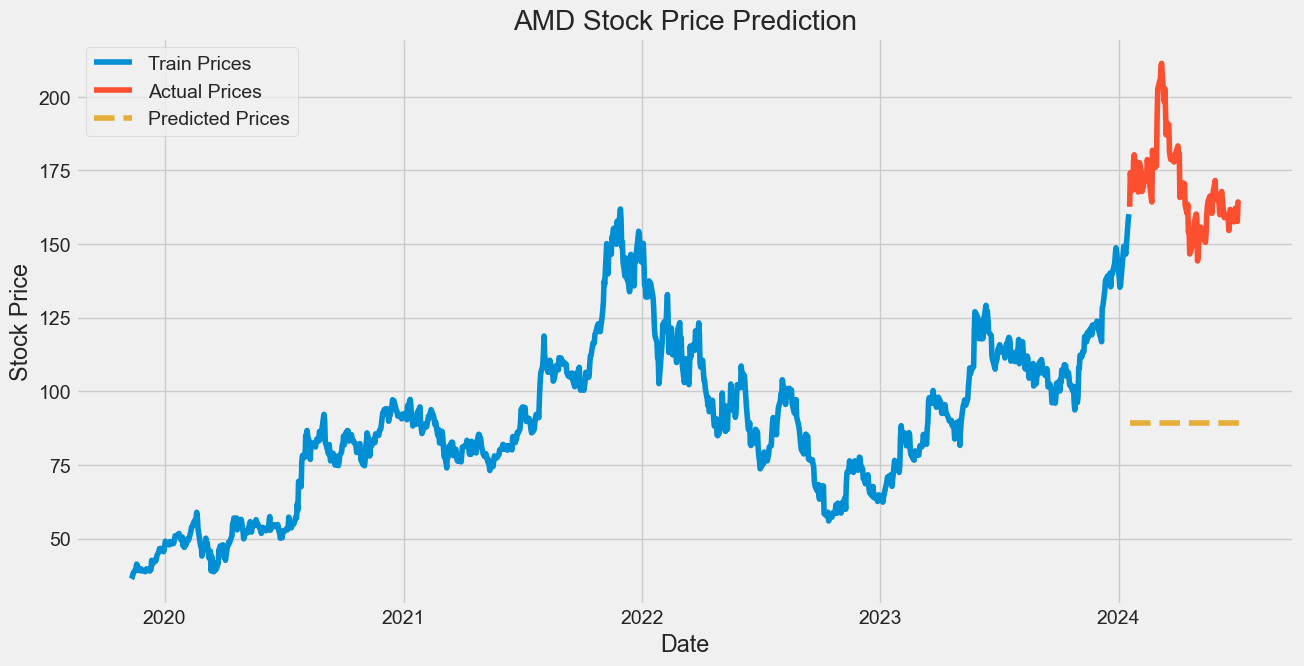

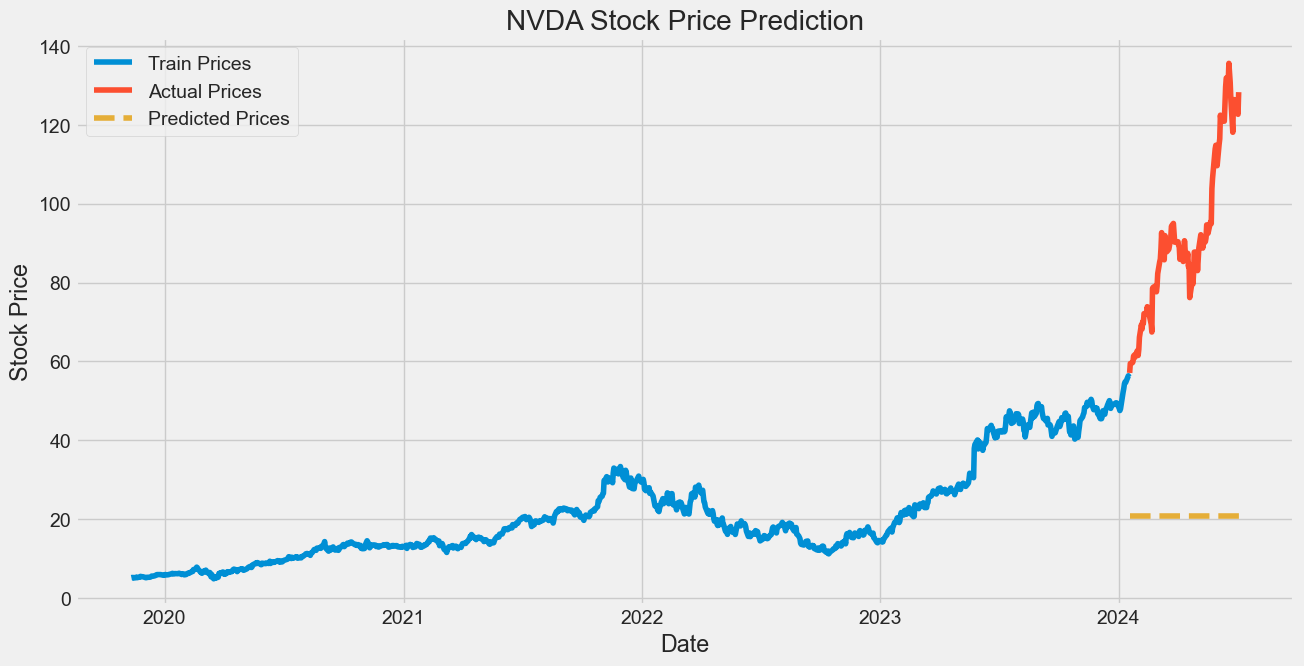

In [321]:
# Visualizing Dummy Regressor prediction.
def plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the dummy regressor.
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    best_model = trained_models[stock]
    plot_predictions(best_model, y_train, X_test, y_test, stock)

# 3.5.0 Modelling:

## 3.5.1 Applying Machine Learning Models:

In [325]:
# fuction to split df into train and test.
def preprocess_data(df):
    X = df.drop(columns=['company_name', 'ticker_symbol'])
    y = df['Close']
     # Calculate the split index
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

processed_data = {}
for stock in tech_list:
    processed_data[stock] = preprocess_data(stock_data[stock])

In [327]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(processed_data['TSLA'][i].shape)
    #print(processed_data['TSLA'][i])

(1052, 13)
(116, 13)
(1052,)
(116,)


In [329]:
# Training Models function. We will explore Linear Regression, DecisionTree Regressor, and Random Forest Regressor.
def train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100)
    }
    trained_models = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = processed_data[stock]
    trained_models[stock] = train_models(X_train, y_train)

In [330]:
def evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = processed_data[stock]
    evaluation_results[stock] = evaluate_models(trained_models[stock], X_test, y_test)

for stock, results in evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    for model_name, metrics in results.items():
        print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")

Evaluation results for TSLA:
Linear Regression: MAE = 4.7000882719610955, RMSE = 6.535051165925837
Decision Tree: MAE = 8.765688402899377, RMSE = 10.960856695510234
Random Forest: MAE = 4.9937724205543255, RMSE = 6.861537577975619
Evaluation results for AMD:
Linear Regression: MAE = 3.7434531041656367, RMSE = 5.123983128863936
Decision Tree: MAE = 18.228793703276537, RMSE = 22.11839781192648
Random Forest: MAE = 15.98076889958875, RMSE = 20.696402541704625
Evaluation results for NVDA:
Linear Regression: MAE = 2.2374221674131043, RMSE = 3.0861504907504402
Decision Tree: MAE = 35.695370805674585, RMSE = 40.76590910028736
Random Forest: MAE = 35.583821765636586, RMSE = 40.709306644391916


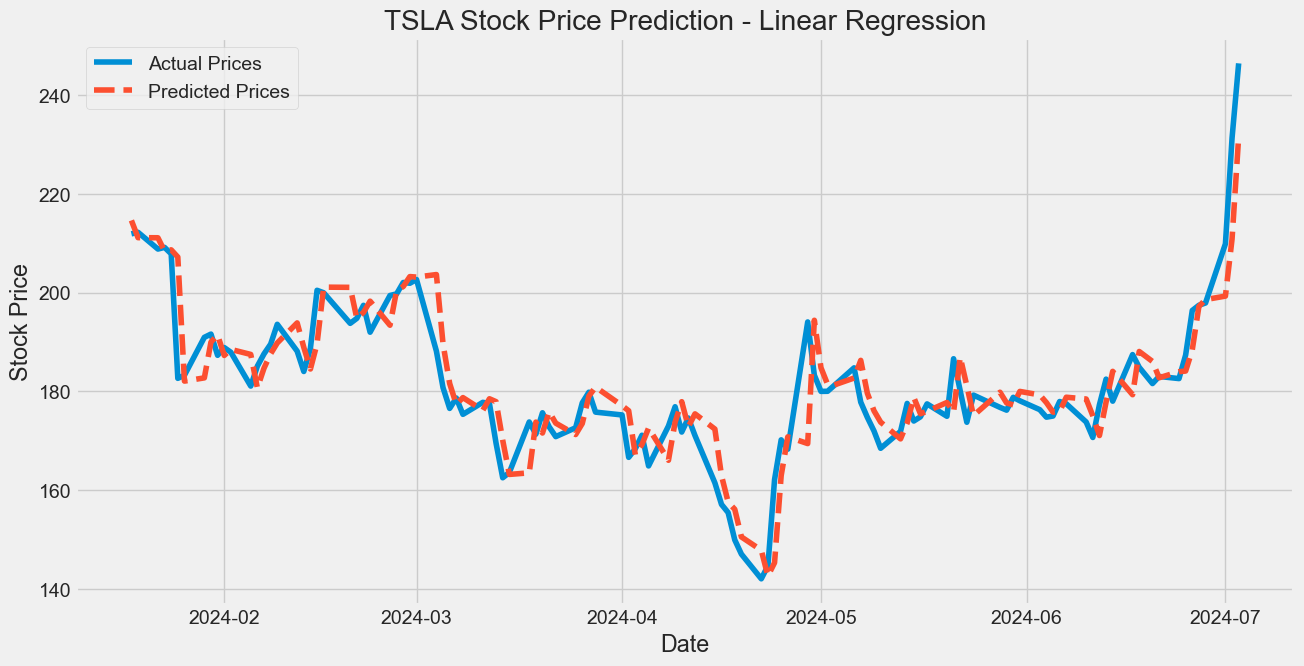

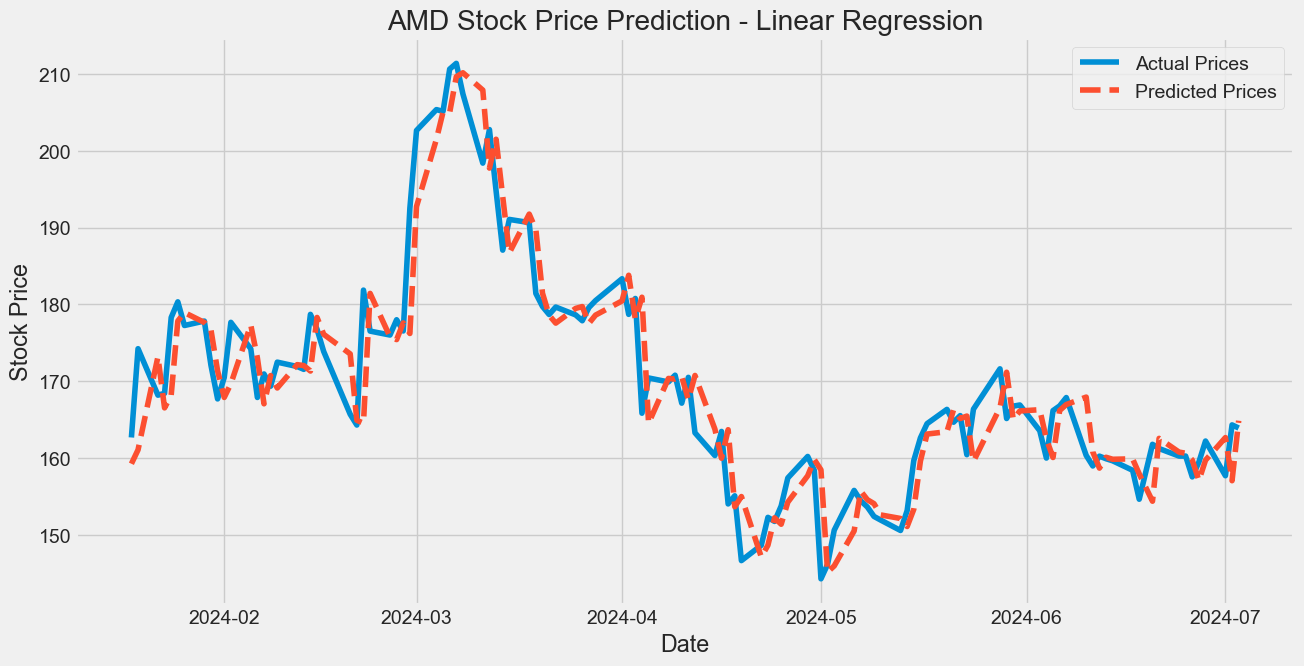

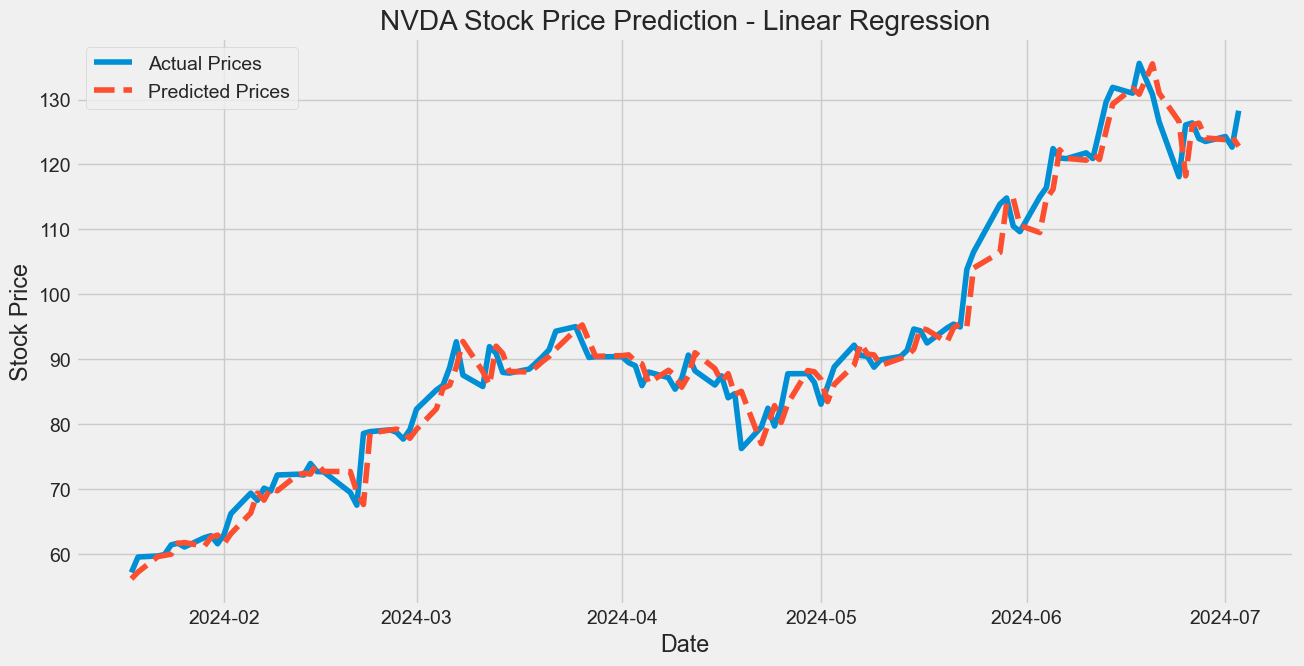

In [333]:
def plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    #print(y_test, predictions)
    plt.figure(figsize=(14, 7))
    #plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction - Linear Regression")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the best model (Random Forest in this example)
for stock in tech_list:
    X_train, X_test, y_train, y_test = processed_data[stock]
    best_model = trained_models[stock]['Linear Regression']
    plot_predictions(best_model, y_train, X_test, y_test, stock)

## 3.5.2 Deep Learning Models:

In [337]:
# Scale DataFrame:
def scale_data(df):
    scale_df = df.drop(columns=['company_name', 'ticker_symbol'])
    scaler = MinMaxScaler()
    # Fit and transform the data
    scaled_data = scaler.fit_transform(scale_df)
    # Convert the scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=scale_df.columns)
    # Add the date index from lstm_df to scaled_df
    scaled_df.index = df.index
    print(scaled_df.shape)
    return scaled_df, scaler

scaled_data = {}
scalers = {}  # Store the scalers for each stock
for stock in tech_list:
    scaled_data[stock], scalers[stock] = scale_data(stock_data[stock])

(1169, 13)
(1169, 13)
(1169, 13)


In [339]:
scaled_data['TSLA'].head()

,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,
2019-11-08,0.000873,0.001053,0.000938,0.001412,0.069671,0.525901,0.000000,0.000000,0.874769,0.422440,0.036036,0.006996,0.001412
2019-11-11,0.002490,0.003046,0.002588,0.002778,0.136093,0.571832,0.000663,0.000259,0.882140,0.423253,0.036036,0.006996,0.002778
2019-11-12,0.002995,0.003247,0.002942,0.003610,0.091546,0.548502,0.001333,0.000536,0.894621,0.424020,0.036036,0.006996,0.003610
2019-11-13,0.004382,0.004259,0.003140,0.002953,0.109531,0.487605,0.001989,0.000804,0.779695,0.424015,0.036036,0.006996,0.002953
2019-11-14,0.002860,0.003836,0.002746,0.003510,0.076380,0.537114,0.002729,0.001060,0.673914,0.423997,0.036036,0.006996,0.003510


In [341]:
def inverse_scale(df,df2, scaler):
    scale_df = df.drop(columns=['company_name', 'ticker_symbol'])
    inverse_df = pd.DataFrame(scaler.inverse_transform(df2), columns=scale_df.columns)
    #inverse_df.index = df.index
    return inverse_df

inverse_df = inverse_scale(stock_data['TSLA'],scaled_data['TSLA'],scalers['TSLA'])
inverse_df.head()

,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
0,22.299999,22.497334,22.166668,22.476000,91038000.0,0.004768,18.476200,16.604963,86.182712,1.485719,0.12,0.01867,22.476000
1,22.930000,23.279333,22.799999,23.006001,149800500.0,0.023581,18.707800,16.687919,86.850537,1.537215,0.12,0.01867,23.006001
2,23.126667,23.358000,22.936001,23.328667,110391000.0,0.014025,18.941667,16.776504,87.981493,1.585782,0.12,0.01867,23.328667
3,23.666668,23.755333,23.011999,23.073999,126301500.0,-0.010916,19.170511,16.862467,77.567972,1.585446,0.12,0.01867,23.073999
4,23.073999,23.589333,22.860666,23.290001,96973500.0,0.009361,19.429000,16.944267,67.983043,1.584346,0.12,0.01867,23.290001


In [343]:
stock_data['TSLA'].head()

,ticker_symbol,company_name,Open,High,Low,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,actualEarningResult,estimatedEarning,Close
Date,,,,,,,,,,,,,,,
2019-11-08,TSLA,TESLA,22.299999,22.497334,22.166668,22.476000,91038000,0.004768,18.476200,16.604963,86.182712,1.485719,0.12,0.01867,22.476000
2019-11-11,TSLA,TESLA,22.930000,23.279333,22.799999,23.006001,149800500,0.023581,18.707800,16.687919,86.850537,1.537215,0.12,0.01867,23.006001
2019-11-12,TSLA,TESLA,23.126667,23.358000,22.936001,23.328667,110391000,0.014025,18.941667,16.776504,87.981493,1.585782,0.12,0.01867,23.328667
2019-11-13,TSLA,TESLA,23.666668,23.755333,23.011999,23.073999,126301500,-0.010916,19.170511,16.862467,77.567972,1.585446,0.12,0.01867,23.073999
2019-11-14,TSLA,TESLA,23.073999,23.589333,22.860666,23.290001,96973500,0.009361,19.429000,16.944267,67.983043,1.584346,0.12,0.01867,23.290001


In [345]:
def create_sequences(X_data, Y_data, seq_length):
    xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        x = X_data[i:i + seq_length]
        y = Y_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
# Function to split DataFrame into train and test sets
def preprocess_data(df, train_split_percentage = 0.80, seq_length = 3):

    # Split DataFrame into X and y
    X = df.drop(columns=['Close'])
    y = df['Close']
    
    # Calculate the split index
    split_index = int(len(X) * train_split_percentage)
    
    # Split the data into training and test sets
    X_train = X.iloc[:split_index]  # Drop last column 'Close'
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]   # Only last column 'Close'
    y_test = y.iloc[split_index:]

    print("Split data shape: ", "X_train: ", X_train.shape, "X_test: ", X_test.shape, "y_train: ", y_train.shape, "y_test: ", y_test.shape)
    
    # Create 3d array for LSTM module. needs to be set with sequence. 
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
    
    print("Sequence Split data shape: ", "X_train_seq: ", X_train_seq.shape, "X_test_seq: ", X_test_seq.shape, "y_train_seq: ", y_train_seq.shape, "y_test_seq: ", y_test_seq.shape)
    
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq

processed_data = {}
for stock in tech_list:
    processed_data[stock] = preprocess_data(scaled_data[stock], train_split_percentage, seq_length)

Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)
Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)
Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)


In [351]:
from sklearn.model_selection import TimeSeriesSplit

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

In [353]:
#Train LSTM models for each stock and store them in a dictionary
trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = processed_data[stock]
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    trained_models[stock] = model

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 30, 50)            12600     
                                                                 
 dropout_36 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_50 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_37 (Dropout)        (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32851 (128.32 KB)
Trainable params: 32851 (128.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequent

3/3 [==============================] - 0s 6ms/step
(87,) (87, 1)
(87,) (87,)
Evaluation results for TSLA:
MAE = 5.778603806321595, RMSE = 8.277803497569051


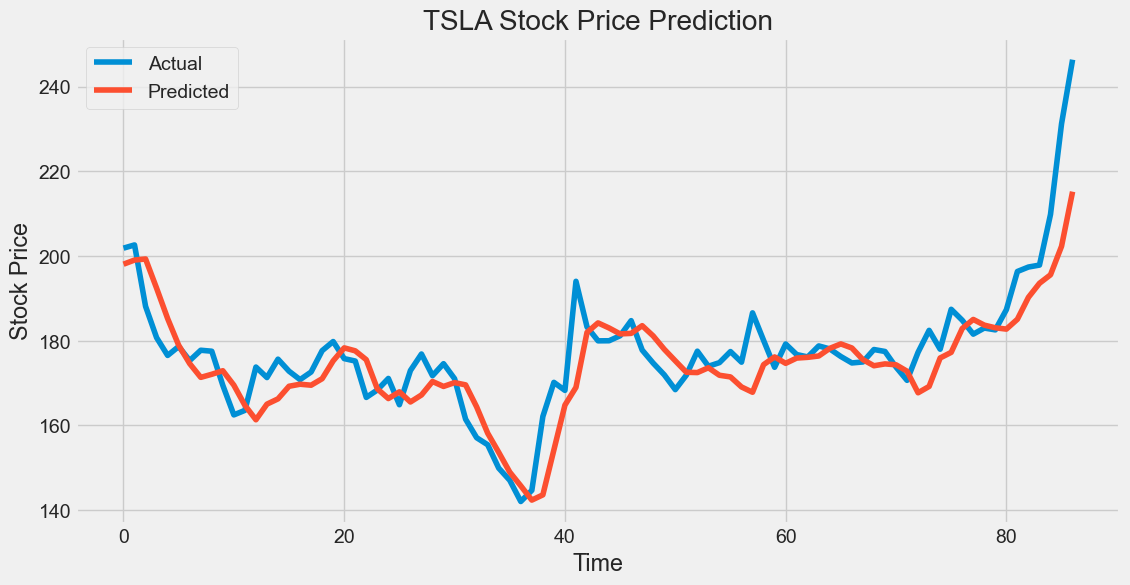

3/3 [==============================] - 0s 5ms/step
(87,) (87, 1)
(87,) (87,)
Evaluation results for AMD:
MAE = 12.969730245420307, RMSE = 14.107993168661913


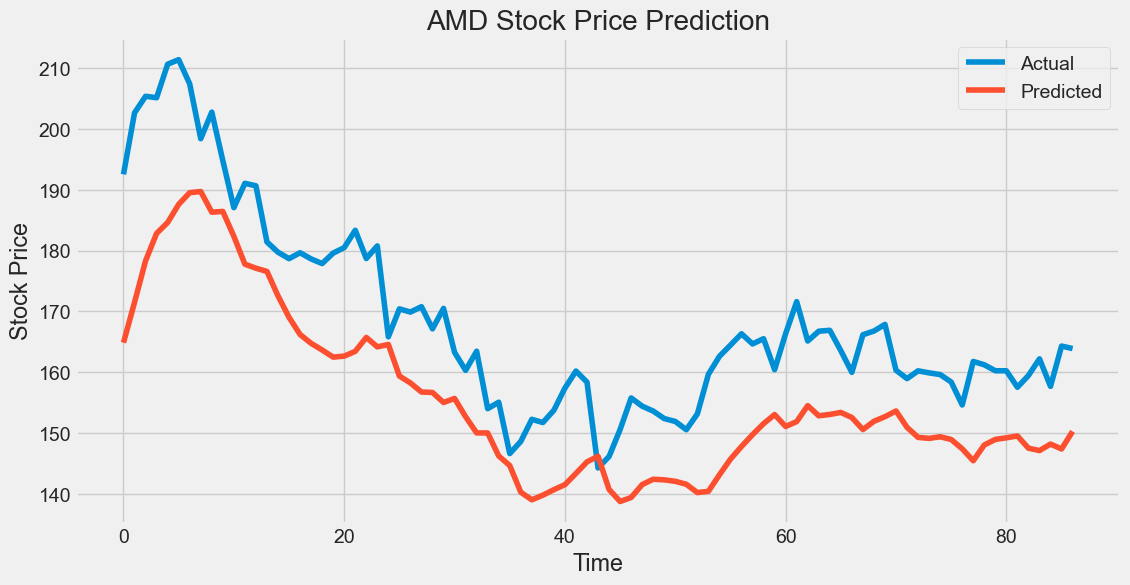

3/3 [==============================] - 0s 6ms/step
(87,) (87, 1)
(87,) (87,)
Evaluation results for NVDA:
MAE = 8.850040477355517, RMSE = 10.751761035921222


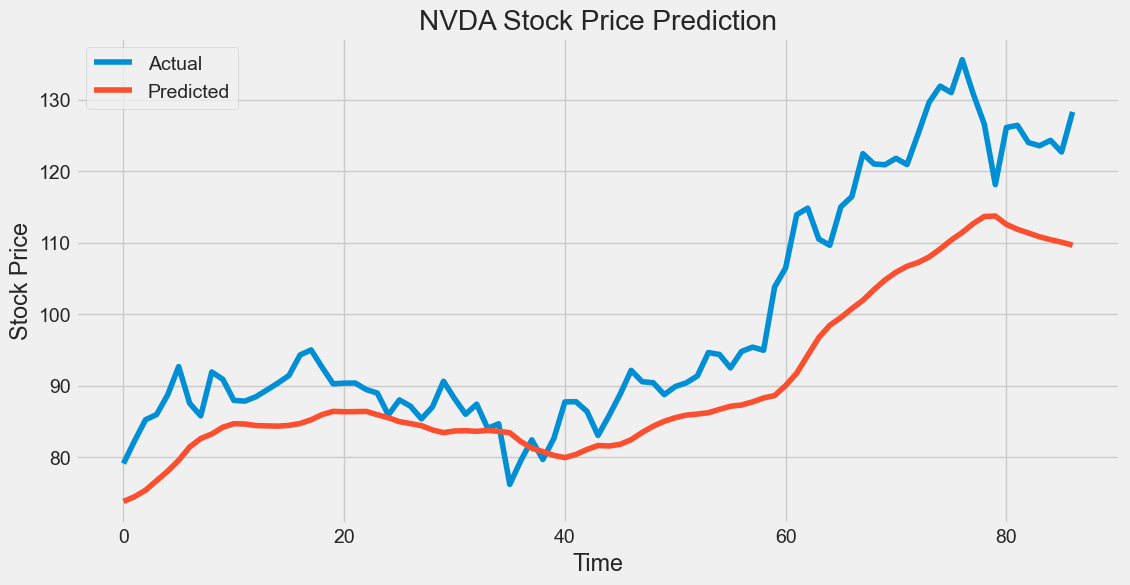

In [359]:
# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    print(y_test.shape, y_pred.shape)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
    print(y_pred_inv.shape, original_ytest.shape)

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(original_ytest, y_pred_inv, stock)

(1169, 13)
(1169, 13)
(1169, 13)
Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)
Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)
Split data shape:  X_train:  (1052, 12) X_test:  (117, 12) y_train:  (1052,) y_test:  (117,)
Sequence Split data shape:  X_train_seq:  (1022, 30, 12) X_test_seq:  (87, 30, 12) y_train_seq:  (1022,) y_test_seq:  (87,)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 30, 50)            12600     
                                                                 
 dropout_42 (Dropout)        

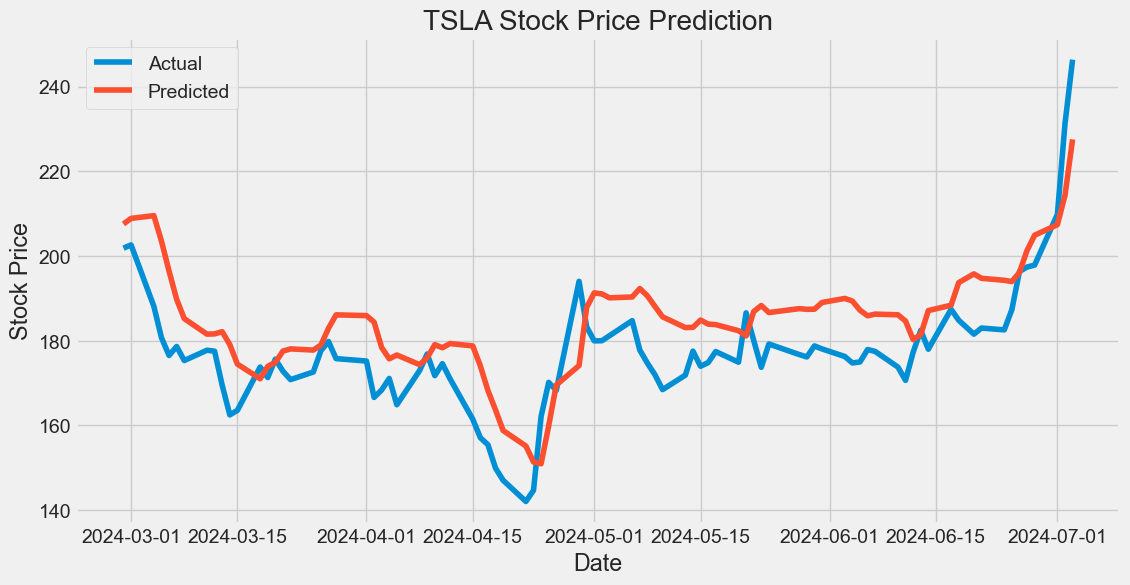

3/3 [==============================] - 1s 6ms/step
Evaluation results for AMD:
MAE = 7.062267321097391, RMSE = 8.789732009222542


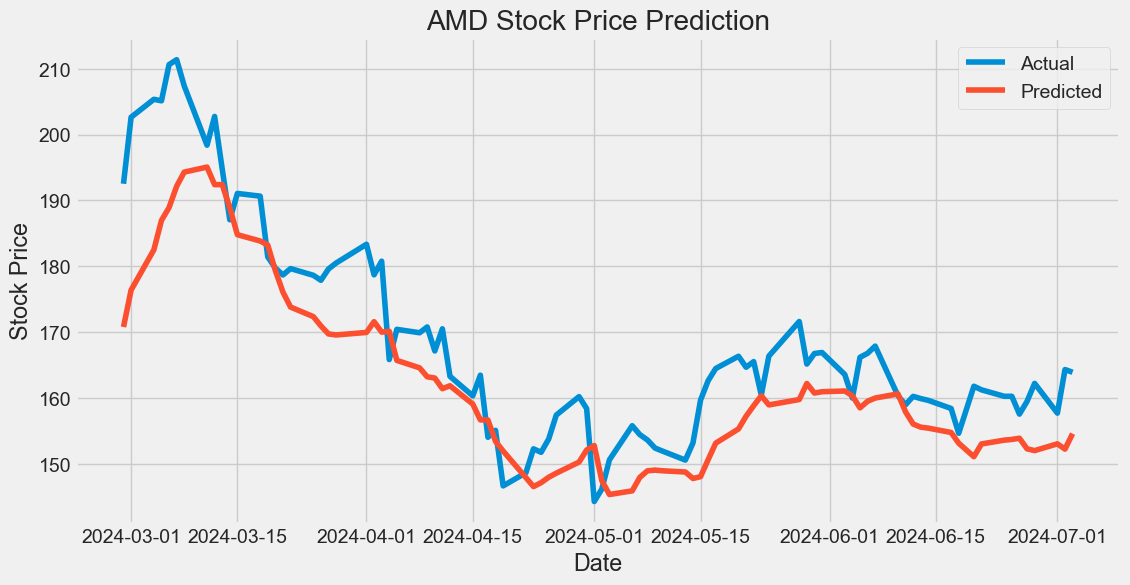

3/3 [==============================] - 1s 6ms/step
Evaluation results for NVDA:
MAE = 10.20072408532032, RMSE = 11.887132156780744


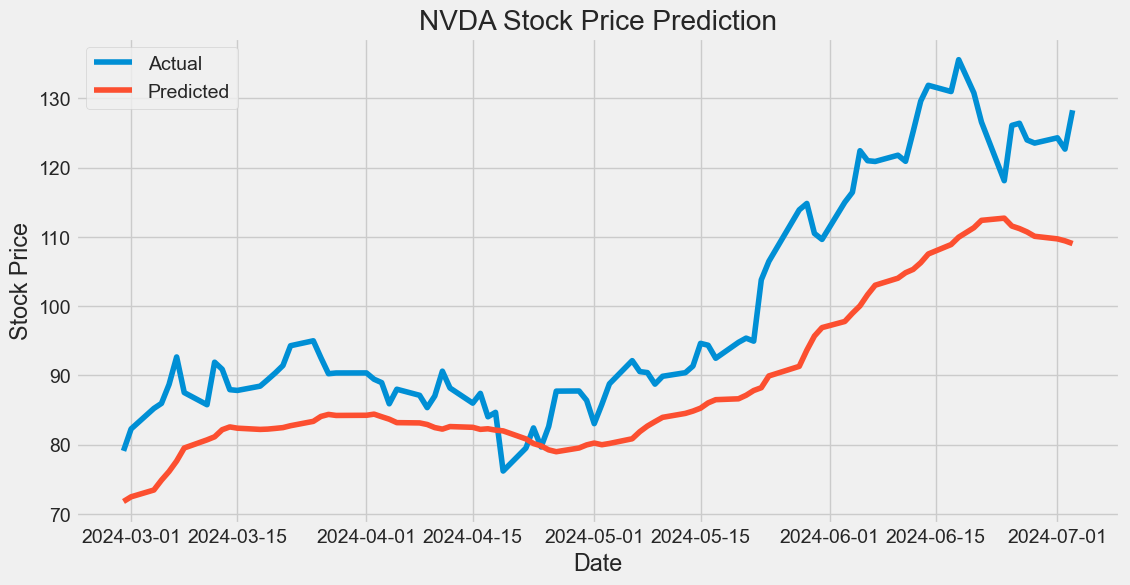

In [361]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming lstm_df is already defined with appropriate columns

# Scale DataFrame:
def scale_data(df):
    scale_df = df.drop(columns=['company_name', 'ticker_symbol'])
    scaler = MinMaxScaler()
    # Fit and transform the data
    scaled_data = scaler.fit_transform(scale_df)
    # Convert the scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=scale_df.columns)
    # Add the date index from original df to scaled_df
    scaled_df.index = df.index
    print(scaled_df.shape)
    return scaled_df, scaler

scaled_data = {}
scalers = {}  # Store the scalers for each stock
for stock in tech_list:
    scaled_data[stock], scalers[stock] = scale_data(stock_data[stock])

def create_sequences(X_data, Y_data, seq_length):
    xs, ys = [], []
    for i in range(len(X_data) - seq_length):
        x = X_data[i:i + seq_length]
        y = Y_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Function to split DataFrame into train and test sets
def preprocess_data(df, train_split_percentage=0.80, seq_length=3):
    # Split DataFrame into X and y
    X = df.drop(columns=['Close'])
    y = df['Close']
    
    # Retain the date index
    dates = df.index
    
    # Calculate the split index
    split_index = int(len(X) * train_split_percentage)
    
    # Split the data into training and test sets
    X_train = X.iloc[:split_index]  # Drop last column 'Close'
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]   # Only last column 'Close'
    y_test = y.iloc[split_index:]
    dates_train = dates[:split_index]
    dates_test = dates[split_index:]

    print("Split data shape: ", "X_train: ", X_train.shape, "X_test: ", X_test.shape, "y_train: ", y_train.shape, "y_test: ", y_test.shape)
    
    # Create 3d array for LSTM module. needs to be set with sequence. 
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
    
    dates_test_seq = dates_test[seq_length:]
    
    print("Sequence Split data shape: ", "X_train_seq: ", X_train_seq.shape, "X_test_seq: ", X_test_seq.shape, "y_train_seq: ", y_train_seq.shape, "y_test_seq: ", y_test_seq.shape)
    
    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, dates_test_seq

processed_data = {}
for stock in tech_list:
    processed_data[stock] = preprocess_data(scaled_data[stock], train_split_percentage, seq_length)

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

# Train LSTM models for each stock and store them in a dictionary
trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, _ = processed_data[stock]
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    trained_models[stock] = model

# Function to evaluate the model
def evaluate_models(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]
    original_ytest = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

    mae = mean_absolute_error(original_ytest, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(original_ytest, y_pred_inv))
    return {'MAE': mae, 'RMSE': rmse}, y_pred_inv, original_ytest

# Function to plot y_pred vs y_test
def plot_predictions(dates, y_test, y_pred, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test, dates_test_seq = processed_data[stock]
    results, y_pred_inv, original_ytest = evaluate_models(trained_models[stock], X_test, y_test, scalers[stock])
    evaluation_results[stock] = results
    
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")
    
    # Plot predictions
    plot_predictions(dates_test_seq, original_ytest, y_pred_inv, stock)
